<h1><font color="#1D65DD" size=6> SISTEMA DE RECONOCIMIENTO DE IMAGENES DE HOMBRES Y MUJERES USANDO REDES NEURONALES CONVOLUCIONALES </font></h1>

<br>

**Autor:** Luis Fernando Gómez Mendoza

**País:** Perú

**Correo:** lgomezm@uni.pe

**Teléfono:** +51 940775686

Soy Bachiller en Ing. Electrónica y egresado de la Maestría en Ciencias de la computación de la Universidad Nacional de Ingeniería (Lima-Perú)

In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import seaborn as sns;
sns.set()
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from random import randint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import random
from time import time
# Model
import tensorflow.python.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,GlobalAvgPool2D, GlobalMaxPool2D, Dropout, BatchNormalization,concatenate, Layer, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

# <font color="#00586D"> 1. Exploracion de Datos Procesados </font>

Los archivos genero.zip fueron descargados y subidos a google drive. Para ejecutarlo desde otra ubicación. Será necesario editar la variable path.

**Ruta:** Se leen y procesan todas las imagenes, contenidas dentro de la carpeta genero. A continuación se almacenan los paths para la carpeta genero, man y woman.

In [2]:
path='/content/drive/MyDrive/Trabajo/PostulaEmpleo/genero/'
path_man=path+'man/'
path_woman=path+'woman/'

Las rutas de caa imagen para hombres y mujeres se almacenan en listas: path_imag_man_ori y path_imag_woman_ori.

In [3]:
#Lectura de archivos:
path_imag_man_ori = [(path_man + x) for x in os.listdir(path_man)]
path_imag_woman_ori = [(path_woman + x) for x in os.listdir(path_woman)]

In [4]:
#Cantidad:
print('Numero total de imagenes original de hombres: ',len(path_imag_man_ori))
print('Numero total de imagenes original de mujeres: ',len(path_imag_woman_ori))

Numero total de imagenes original de hombres:  800
Numero total de imagenes original de mujeres:  800


Se extrae el 10% de imagenes tanto de hombres como de mujeres, para la fase de test, con el modelo ya entrenado. Mientras que el 90% servira para el entrenamiento y validacion del modelo.

In [5]:
#ISe extrae el 10% de imagenes de hombres de manera aleatoria para la validez de la prediccion
path_imag_man_pred=random.sample(path_imag_man_ori,int(0.1*len(path_imag_man_ori)))
path_imag_man=[x for x in path_imag_man_ori if x not in path_imag_man_pred]

#Se extrae el 10% de imagenes de mujeres de manera aleatoria para la validez de la prediccion
path_imag_woman_pred=random.sample(path_imag_woman_ori,int(0.1*len(path_imag_woman_ori)))
path_imag_woman=[x for x in path_imag_woman_ori if x not in path_imag_woman_pred]

#Cantidad:
print('Numero total de imagenes de hombres para train-validation: ',len(path_imag_man))
print('Numero total de imagenes original de mujeres para train-validation: ',len(path_imag_woman))
print('Numero total de imagenes de hombres para test: ',len(path_imag_man_pred))
print('Numero total de imagenes original de mujeres para test: ',len(path_imag_woman_pred))

Numero total de imagenes de hombres para train-validation:  720
Numero total de imagenes original de mujeres para train-validation:  720
Numero total de imagenes de hombres para test:  80
Numero total de imagenes original de mujeres para test:  80


A continuación se muestra un conjunto de imágenes de hombres y mujeres respectivamente por cada fila.

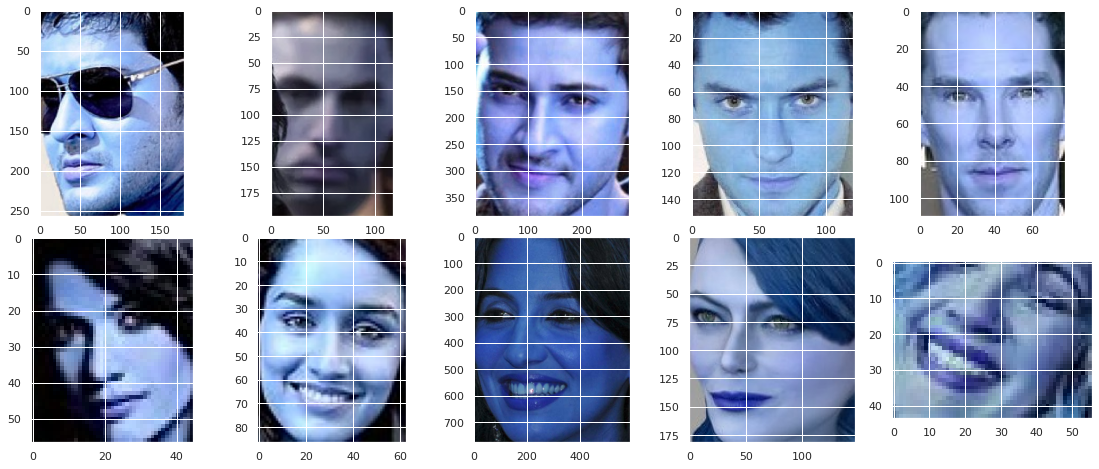

In [6]:
#Imagenes de muestra:
np.random.seed(1)
fig, axis = plt.subplots(2,5, figsize=(15,15))
for j in range(5):
  imag_sel=np.random.randint(0,len(path_imag_man))
  axis[0,j].imshow(cv2.imread(path_imag_man[imag_sel]),cmap='gray')
  axis[1,j].imshow(cv2.imread(path_imag_woman[imag_sel]),cmap='gray')
# Hide x labels and tick labels for top plots and y ticks for right plots.
plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0, right=1, bottom=0, top=0.4)

A continuación se calcula las dimensiones máximas y mínimas de cada imagen, para obtener la dimensión de escalado.

In [7]:
#Saber el size min y max de cada imagen
len_wmin=np.min([len(cv2.imread(x)[0]) for x in path_imag_man])
len_hmin=np.min([len(cv2.imread(x)[1]) for x in path_imag_man])

print('Ancho minimo =',len_wmin,' | Altura minima =',len_hmin )
len_image=min([len_wmin,len_hmin])
print('longitud minima elegida para el redimensionado: len_image=',len_image)



Ancho minimo = 25  | Altura minima = 25
longitud minima elegida para el redimensionado: len_image= 25


Como se puede apreciar,las imagenes estan balanceadas.

# <font color="#00586D"> 2. Preprocesamiento de imagenes </font>

Se realiza operaciones para homogenizar dimensiones de las imágenes.

In [8]:
#Funcion que pre-procesa la imagen rgb a gray,la escala y la normaliza.
def pre_imagen(path,len_imagen):
  #Se lee la imagen y se convierte a gray(0)
  x=cv2.imread(path,0) 
  #Se modifica el tamano: a (len_imagenxlen_imagen)
  x=cv2.resize(x, (len_imagen,len_imagen), interpolation=cv2.INTER_AREA)
  #Normalizacion de la imagen:
  x=(x-x.mean())/x.std();
  return x

Etiquetado de las imagenes y almacenamiento en un array. Se asigna el valor de y=1 a la clase asignada para los hombres, mientras que y=0 a la clase asignada a las mujeres.

In [9]:
#Prediciendo resultados:
#Procesando imagenes:
#Se crean las variables X e y.
def getXYImage(path_man,path_woman,len_imag):
  Xt=np.empty(shape=(0,len_image,len_image))
  yt=np.array([])

  #Procesamiento de las imagenes asociadas a los hombres
  start = time() #Midiendo el tiempo
  for path in path_man:
      Xt=np.append(Xt,[pre_imagen(path,len_image)],axis=0)
      yt=np.append(yt,1.0)

  print("Tiempo de procesar las imagenes de hombres: {:0.3f}s.".format(time() - start))
  #=======================================================================================
  #Preprocesamiento de las imagenes asociadas as las mujeres.
  start = time() #Midiendo el tiempo
  for path in path_woman:
      Xt=np.append(Xt,[pre_imagen(path,len_image)],axis=0)
      yt=np.append(yt,0.0)
  print("Tiempo de procesar las imagenes de mujeres: {:0.3f}s.".format(time() - start))

  return Xt.copy(),yt.copy()

In [10]:
#Procesando imagenes para train-validation:
X,y=getXYImage(path_imag_man,path_imag_woman,len_image)


Tiempo de procesar las imagenes de hombres: 3.342s.
Tiempo de procesar las imagenes de mujeres: 199.148s.


In [11]:
#Procesando imagenes para el test de prediccion
x_final,y_final=getXYImage(path_imag_man_pred,path_imag_woman_pred,len_image)

Tiempo de procesar las imagenes de hombres: 0.294s.
Tiempo de procesar las imagenes de mujeres: 21.886s.


In [12]:
print("Dimension de la matriz X para el train-val: ",X.shape)
print("Dimension de la matriz y para el train-val",y.shape)
print("Dimension de la matriz X para el test de prediccion: ",x_final.shape)
print("Dimension de la matriz y para el test de prediccion",y_final.shape)

Dimension de la matriz X para el train-val:  (1440, 25, 25)
Dimension de la matriz y para el train-val (1440,)
Dimension de la matriz X para el test de prediccion:  (160, 25, 25)
Dimension de la matriz y para el test de prediccion (160,)


Vista de las imagenes preprocesadas

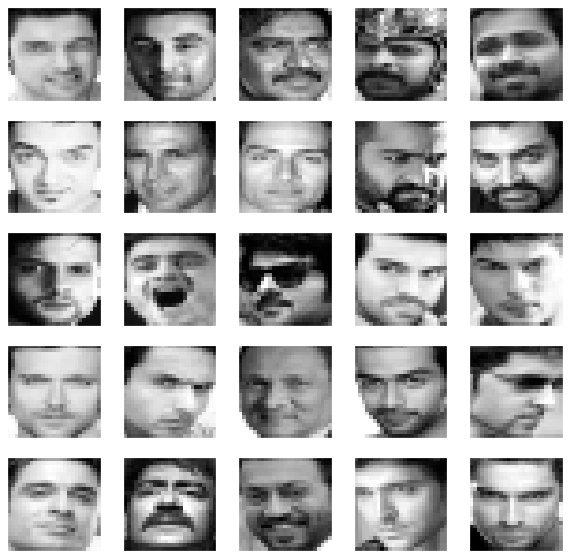

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i],cmap='gray')
    
plt.show()

# <font color="#00586D"> 3. Division de los datos para el entrenamiento-test y prediccion </font>

In [14]:
x_train, x_test,y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=0,stratify=y)

Se redimensionan de ndim=3 a ndim=2 las variables x_train, x_test y x_final.

In [15]:
# Ajustamos las dimensiones de las imágenes
if x_train.ndim == 3:
    x_train = x_train[...,None]
    x_test = x_test[..., None]
    x_final= x_final[...,None]
    print(x_train.shape, x_test.shape,x_final.shape)

(1224, 25, 25, 1) (216, 25, 25, 1) (160, 25, 25, 1)


# <font color="#00586D"> 4. Entrenamiento </font>

In [16]:
#Funcion para plotear y guardar el modelo.
def plot_model_and_save_image(model, file_name="model.png"):   
    from tensorflow.keras.utils import plot_model
    return plot_model(model, to_file=file_name, show_shapes=True)

#Funcion para guardar los pesos.
def save_weights(model, file):
    model.save_weights(file, overwrite=True)

#Funcion cargar pesos.
def reset_weights(model, file):
    model.load_weights(file)

Se crea el modelo con batch size=256, learning rate =0.01. El modelo incluye 5 capas convolucionales CNN con strides de 2 y activación relu.  Se concatenan con batch normalization. Posteriormente se emplea un global average pool y global Max Pool. Los resultados son concatenados. Para reducir el oversampling se emplea un dropout de 0.25. Finalmente se agrega una capa densa con activación softmax de  2 clases para la salida.

In [18]:
K.clear_session()

lr = 0.01
bs = 256
nb = np.ceil(len(x_train)/bs) # Nro de batches
l2_w = 1e-4

model_in = Input((len_image,len_image,1))

x = model_in
for k in [32,64,64,256,128]:
  x = Conv2D(k, 3, strides=2,padding='same',activation='relu', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(l2_w))(x)
  x = BatchNormalization()(x)

x_avg = GlobalAvgPool2D()(x)
x_max = GlobalMaxPool2D()(x)
x = concatenate([x_avg, x_max])
x = Dropout(0.25)(x)

model_out = Dense(2, activation='softmax', kernel_regularizer=l2(l2_w))(x)

model = Model(model_in, model_out)

model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
save_weights(model, 'model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 13, 13, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 13, 13, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18432       ['batch_normalization[0][0]']

Se muestra a continuación la arquitectura del modelo propuesto.

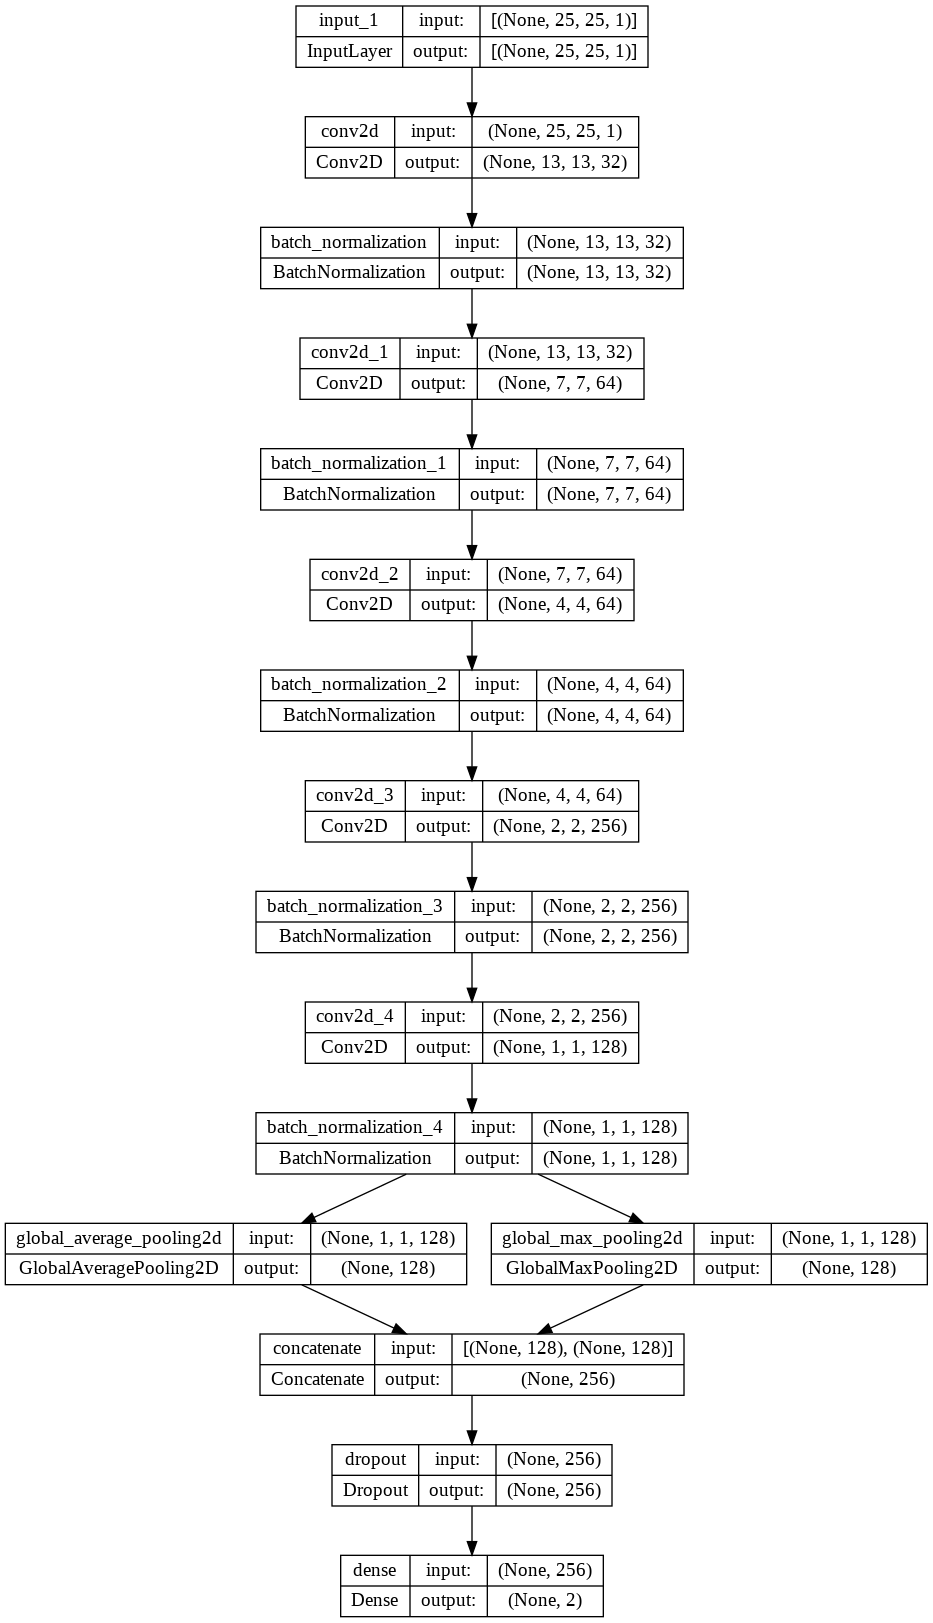

In [19]:
#Graficando el modelo:
plot_model_and_save_image(model, file_name="model.png")

Se define un early stopping con patience=15.

In [20]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=15, mode="max")
callbacks = [early_stopping] 

Inicia el entrenamiento del modelo con 50 epocas.

In [21]:
# Trainning

log = model.fit(x_train, y_train, batch_size=bs, epochs=50,callbacks=callbacks, validation_data=(x_test, y_test))


Epoch 1/50
5/5 [==============================] - 13s 167ms/step - loss: 1.9375 - accuracy: 0.6283 - val_loss: 8.3038 - val_accuracy: 0.5972
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.7050 - accuracy: 0.7304 - val_loss: 24.2296 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 0.5486 - accuracy: 0.8448 - val_loss: 48.1466 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 25ms/step - loss: 0.4506 - accuracy: 0.8856 - val_loss: 40.3299 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3922 - accuracy: 0.9183 - val_loss: 37.7408 - val_accuracy: 0.5000
Epoch 6/50
5/5 [==============================] - 0s 28ms/step - loss: 0.3442 - accuracy: 0.9436 - val_loss: 32.9536 - val_accuracy: 0.5000
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.3011 - accuracy: 0.9665 - val_loss: 21.7062 - val_accuracy: 0.5185
Epoch 8/50
5/5 [===

Se despliega el loss y val_loss del train y validation

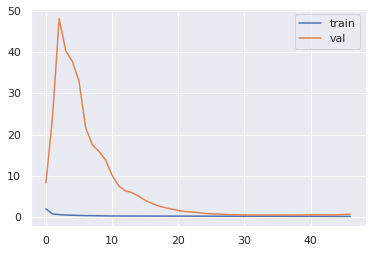

In [22]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='val')
plt.legend();

Se crea una funcion para mostrar los resultados del Loss y el Accuracy.

In [23]:
#Muestra resultados:
def show_results(model, log):
    loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

Loss     = 0.6255
Accuracy = 0.8565


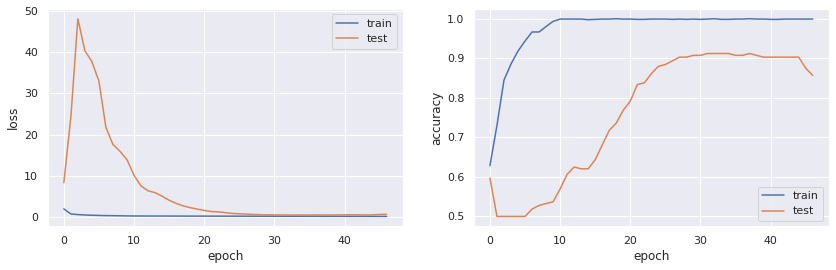

In [24]:
show_results(model, log)

Guardando el modelo para su posterior descarga:

In [25]:
model.save('ModeloGenero.h5')

# <font color="#00586D"> 5. Prediccion </font>

Se predice los resultados a partir de los datos almacenados previamente (10%) para el test.

In [26]:
y_predict=np.argmax(model.predict(x_final),axis=1)

5/5 [==============================] - 0s 8ms/step


Se crea una funcion para observar la matriz de confusion y las principales métricas.

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_results(y, y_pred):
    from sklearn.metrics import confusion_matrix
    c_mat = confusion_matrix(y,y_pred)
    c_mat = c_mat/c_mat.sum(axis=1)
    class_names=["mujer","hombre"]
    plt.figure(figsize=(10, 10))
    plt.title('clasificacion del Genero usando CNN')
    c_mat_df=pd.DataFrame(c_mat,index=class_names,columns=class_names)
    sns.heatmap(c_mat_df, square=True, annot=True, fmt='.2f', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados: ")
    print(f'\taccuracy: {accuracy_score(y_true=y,y_pred=y_pred):.3f}')
    print(f'\trecall: {recall_score(y_true=y,y_pred=y_pred):.3f}')
    print(f'\tprecision: {precision_score(y_true=y,y_pred=y_pred):.3f}')
    print(f'\tf1_score: {f1_score(y_true=y,y_pred=y_pred):.3f}')

Finalmente se muestran los resultados de la predicción del modelo de reconocimiento de género.

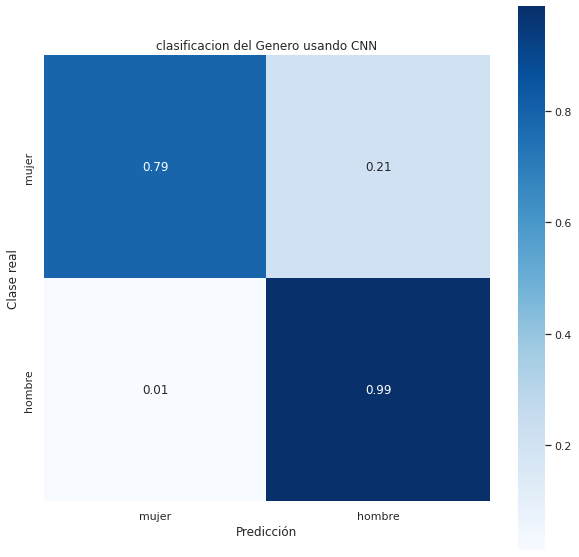

Resultados: 
	accuracy: 0.887
	recall: 0.988
	precision: 0.823
	f1_score: 0.898


In [28]:
show_results(y_final,y_predict)